# Baseline

In [2]:
!pip install torch_geometric

In [2]:
!git clone --branch baselineCe https://github.com/Graph-Classification-Noisy-Label/hackaton.git

Cloning into 'hackaton'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 69 (delta 1), reused 0 (delta 0), pack-reused 62 (from 2)
Receiving objects: 100% (69/69), 105.83 MiB | 46.69 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
%cd hackaton/

/home/onyxia/work/DL-Hackathon/hackaton


In [4]:
!gdown --folder https://drive.google.com/drive/folders/1Z-1JkPJ6q4C6jX4brvq1VRbJH5RPUCAk -O datasets


Retrieving folder contents
Retrieving folder 1wcUVBNQkZ04zStXkglXSgERfIvjSHJiL A
Processing file 1C8sjkO6JS0j2SyVwQ07m8PhQ-pHpuI78 test.json.gz
Processing file 12N11n8gufNA_C1ns-1IeBseBHgrSfRI1 train.json.gz
Retrieving folder 1Tj5YoYYDDXjDxxi-cywZgoDkT0b1Qbz- B
Processing file 11GBlrXMdP3HSD60w-56Tu6rbGkR-Ifww test.json.gz
Processing file 13vp-Kwef3UgAwMG-dokGwKyARym9iqtL train.json.gz
Retrieving folder 1e3B_tBMd693Iwv8x3zRR9c47l5yt_5ey C
Processing file 18XVe65ZsQ0PDLCqQa4WmneVhyfjGcXmT test.json.gz
Processing file 1z5lvG2CytbLQZt7Jmo9BopzFd0pKejEj train.json.gz
Retrieving folder 1cvM0eZwpD4gzjo44_zdodxudVBMrLza1 D
Processing file 1Gna_dHnBLX8vKaYGAAqAbw5QPerrNK1u test.json.gz
Processing file 1Pc-6LMML80-AgEoLVs2Q5hLtmR_rTEek train.json.gz
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1C8sjkO6JS0j2SyVwQ07m8PhQ-pHpuI78
From (redirected): https://drive.google.com/uc?

In [4]:
!ls -lh datasets

total 16K
drwxr-sr-x 2 onyxia users 4.0K May 24 18:25 A
drwxr-sr-x 2 onyxia users 4.0K May 24 18:25 B
drwxr-sr-x 2 onyxia users 4.0K May 24 18:25 C
drwxr-sr-x 2 onyxia users 4.0K May 24 18:25 D


In [ ]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
# Load utility functions from cloned repository
from src.loadData import GraphDataset
from src.utils import set_seed
from src.models import GNN
import argparse

# Set the random seed
set_seed()


def add_zeros(data):
    data.x = torch.zeros(data.num_nodes, dtype=torch.long)
    return data

def train(data_loader, model, optimizer, criterion, device, save_checkpoints, checkpoint_path, current_epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data in tqdm(data_loader, desc="Iterating training graphs", unit="batch"):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)

    # Save checkpoints if required
    if save_checkpoints:
        checkpoint_file = f"{checkpoint_path}_epoch_{current_epoch + 1}.pth"
        torch.save(model.state_dict(), checkpoint_file)
        print(f"Checkpoint saved at {checkpoint_file}")

    return total_loss / len(data_loader),  correct / total

def evaluate(data_loader, model, device, calculate_accuracy=False):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    total_loss = 0
    criterion = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for data in tqdm(data_loader, desc="Iterating eval graphs", unit="batch"):
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            
            if calculate_accuracy:
                correct += (pred == data.y).sum().item()
                total += data.y.size(0)
                total_loss += criterion(output, data.y).item()
            else:
                predictions.extend(pred.cpu().numpy())
    if calculate_accuracy:
        accuracy = correct / total
        return  total_loss / len(data_loader),accuracy
    return predictions

def save_predictions(predictions, test_path):
    script_dir = os.getcwd() 
    submission_folder = os.path.join(script_dir, "submission")
    test_dir_name = os.path.basename(os.path.dirname(test_path))
    
    os.makedirs(submission_folder, exist_ok=True)
    
    output_csv_path = os.path.join(submission_folder, f"testset_{test_dir_name}.csv")
    
    test_graph_ids = list(range(len(predictions)))
    output_df = pd.DataFrame({
        "id": test_graph_ids,
        "pred": predictions
    })
    
    output_df.to_csv(output_csv_path, index=False)
    print(f"Predictions saved to {output_csv_path}")

def plot_training_progress(train_losses, train_accuracies, output_dir):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss", color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy", color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy per Epoch')

    # Save plots in the current directory
    os.makedirs(output_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "training_progress.png"))
    plt.close()

def get_user_input(prompt, default=None, required=False, type_cast=str):

    while True:
        user_input = input(f"{prompt} [{default}]: ")
        
        if user_input == "" and required:
            print("This field is required. Please enter a value.")
            continue
        
        if user_input == "" and default is not None:
            return default
        
        if user_input == "" and not required:
            return None
        
        try:
            return type_cast(user_input)
        except ValueError:
            print(f"Invalid input. Please enter a valid {type_cast.__name__}.")

def get_arguments():
    args = {}
    args['train_path'] = get_user_input("Path to the training dataset (optional)")
    args['test_path'] = get_user_input("Path to the test dataset", required=True)
    args['num_checkpoints'] = get_user_input("Number of checkpoints to save during training", type_cast=int)
    args['device'] = get_user_input("Which GPU to use if any", default=1, type_cast=int)
    args['gnn'] = get_user_input("GNN type (gin, gin-virtual, gcn, gcn-virtual)", default='gin')
    args['drop_ratio'] = get_user_input("Dropout ratio", default=0.0, type_cast=float)
    args['num_layer'] = get_user_input("Number of GNN message passing layers", default=5, type_cast=int)
    args['emb_dim'] = get_user_input("Dimensionality of hidden units in GNNs", default=300, type_cast=int)
    args['batch_size'] = get_user_input("Input batch size for training", default=32, type_cast=int)
    args['epochs'] = get_user_input("Number of epochs to train", default=10, type_cast=int)
    args['baseline_mode'] = get_user_input("Baseline mode: 1 (CE), 2 (Noisy CE)", default=1, type_cast=int)
    args['noise_prob'] = get_user_input("Noise probability p (used if baseline_mode=2)", default=0.2, type_cast=float)

    
    return argparse.Namespace(**args)


def populate_args(args):
    print("Arguments received:")
    for key, value in vars(args).items():
        print(f"{key}: {value}")
args = get_arguments()
populate_args(args)

class NoisyCrossEntropyLoss(torch.nn.Module):
    def __init__(self, p_noisy):
        super().__init__()
        self.p = p_noisy
        self.ce = torch.nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits, targets):
        losses = self.ce(logits, targets)
        weights = (1 - self.p) + self.p * (1 - torch.nn.functional.one_hot(targets, num_classes=logits.size(1)).float().sum(dim=1))
        return (losses * weights).mean()

script_dir = os.getcwd() 
# device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_checkpoints = args.num_checkpoints if args.num_checkpoints else 3
    
if args.gnn == 'gin':
    model = GNN(gnn_type='gin', num_class=6, num_layer=args.num_layer, emb_dim=args.emb_dim, drop_ratio=args.drop_ratio, virtual_node=False).to(device)
elif args.gnn == 'gin-virtual':
    model = GNN(gnn_type='gin', num_class=6, num_layer=args.num_layer, emb_dim=args.emb_dim, drop_ratio=args.drop_ratio, virtual_node=True).to(device)
elif args.gnn == 'gcn':
    model = GNN(gnn_type='gcn', num_class=6, num_layer=args.num_layer, emb_dim=args.emb_dim, drop_ratio=args.drop_ratio, virtual_node=False).to(device)
elif args.gnn == 'gcn-virtual':
    model = GNN(gnn_type='gcn', num_class=6, num_layer=args.num_layer, emb_dim=args.emb_dim, drop_ratio=args.drop_ratio, virtual_node=True).to(device)
else:
    raise ValueError('Invalid GNN type')
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = torch.nn.CrossEntropyLoss()
if args.baseline_mode == 2:
    criterion = NoisyCrossEntropyLoss(args.noise_prob)
else:
    criterion = torch.nn.CrossEntropyLoss()

test_dir_name = os.path.basename(os.path.dirname(args.test_path))
logs_folder = os.path.join(script_dir, "logs", test_dir_name)
log_file = os.path.join(logs_folder, "training.log")
os.makedirs(os.path.dirname(log_file), exist_ok=True)
logging.basicConfig(filename=log_file, level=logging.INFO, format='%(asctime)s - %(message)s')
logging.getLogger().addHandler(logging.StreamHandler())

checkpoint_path = os.path.join(script_dir, "checkpoints", f"model_{test_dir_name}_best.pth")
checkpoints_folder = os.path.join(script_dir, "checkpoints", test_dir_name)
os.makedirs(checkpoints_folder, exist_ok=True)


if os.path.exists(checkpoint_path) and not args.train_path:
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Loaded best model from {checkpoint_path}")

if args.train_path:
    full_dataset = GraphDataset(args.train_path, transform=add_zeros)
    val_size = int(0.2 * len(full_dataset))
    train_size = len(full_dataset) - val_size

    
    generator = torch.Generator().manual_seed(12)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)

    num_epochs = args.epochs
    best_val_accuracy = 0.0   

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    if num_checkpoints > 1:
        checkpoint_intervals = [int((i + 1) * num_epochs / num_checkpoints) for i in range(num_checkpoints)]
    else:
        checkpoint_intervals = [num_epochs]

    for epoch in range(num_epochs):
        train_loss, train_acc = train(
            train_loader, model, optimizer, criterion, device,
            save_checkpoints=(epoch + 1 in checkpoint_intervals),
            checkpoint_path=os.path.join(checkpoints_folder, f"model_{test_dir_name}"),
            current_epoch=epoch
        )

        val_loss,val_acc = evaluate(val_loader, model, device, calculate_accuracy=True)

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        logging.info(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best model updated and saved at {checkpoint_path}")

    plot_training_progress(train_losses, train_accuracies, os.path.join(logs_folder, "plots"))
    plot_training_progress(val_losses, val_accuracies, os.path.join(logs_folder, "plotsVal"))

In [ ]:
import gc
del train_dataset
del train_loader
del full_dataset
del val_dataset
del val_loader
gc.collect()

In [ ]:
test_dataset = GraphDataset(args.test_path, transform=add_zeros)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    

In [ ]:
model.load_state_dict(torch.load(checkpoint_path))
predictions = evaluate(test_loader, model, device, calculate_accuracy=False)
save_predictions(predictions, args.test_path)

# Looking at the data

## Imports

In [3]:
!pip install torch_geometric

In [3]:
!git clone --branch baselineCe https://github.com/Graph-Classification-Noisy-Label/hackaton.git

fatal: destination path 'hackaton' already exists and is not an empty directory.


In [4]:
%cd hackaton/

/home/onyxia/work/DL-Hackathon/hackaton


In [4]:
!gdown --folder https://drive.google.com/drive/folders/1Z-1JkPJ6q4C6jX4brvq1VRbJH5RPUCAk -O datasets


Retrieving folder contents
Retrieving folder 1wcUVBNQkZ04zStXkglXSgERfIvjSHJiL A
Processing file 1C8sjkO6JS0j2SyVwQ07m8PhQ-pHpuI78 test.json.gz
Processing file 12N11n8gufNA_C1ns-1IeBseBHgrSfRI1 train.json.gz
Retrieving folder 1Tj5YoYYDDXjDxxi-cywZgoDkT0b1Qbz- B
Processing file 11GBlrXMdP3HSD60w-56Tu6rbGkR-Ifww test.json.gz
Processing file 13vp-Kwef3UgAwMG-dokGwKyARym9iqtL train.json.gz
Retrieving folder 1e3B_tBMd693Iwv8x3zRR9c47l5yt_5ey C
Processing file 18XVe65ZsQ0PDLCqQa4WmneVhyfjGcXmT test.json.gz
Processing file 1z5lvG2CytbLQZt7Jmo9BopzFd0pKejEj train.json.gz
Retrieving folder 1cvM0eZwpD4gzjo44_zdodxudVBMrLza1 D
Processing file 1Gna_dHnBLX8vKaYGAAqAbw5QPerrNK1u test.json.gz
Processing file 1Pc-6LMML80-AgEoLVs2Q5hLtmR_rTEek train.json.gz
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1C8sjkO6JS0j2SyVwQ07m8PhQ-pHpuI78
From (redirected): https://drive.google.com/uc?

In [5]:
!ls -lh datasets

total 16K
drwxr-sr-x 2 onyxia users 4.0K May 24 18:25 A
drwxr-sr-x 2 onyxia users 4.0K May 24 18:25 B
drwxr-sr-x 2 onyxia users 4.0K May 24 18:25 C
drwxr-sr-x 2 onyxia users 4.0K May 24 18:25 D


In [6]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
# Load utility functions from cloned repository
from src.loadData import GraphDataset
from src.utils import set_seed
from src.models import GNN
import argparse

## Dataset A - Train

In [7]:
full_dataset = GraphDataset('datasets/A/train.json.gz')

In [13]:
full_dataset

GraphDataset(11280)

In [12]:
full_dataset[0]

Data(edge_index=[2, 3544], edge_attr=[3544, 7], y=[1], num_nodes=300)

In [16]:
# Print the features of edges : 1 raw = features for 1 edge
full_dataset[0].edge_attr

tensor([[0.5460, 0.0000, 0.7760,  ..., 0.3390, 0.0000, 0.5130],
        [0.5460, 0.0000, 0.7760,  ..., 0.3390, 0.0000, 0.5130],
        [0.8550, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0610, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6690],
        [0.3810, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6540],
        [0.3810, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6540]])

In [15]:
# Print all the labels, of every graphs

count = 0

for i in range (len(full_dataset)):
    print(full_dataset[i].y)
    count += 1

print('Number of graph :', count)

tensor([4])
tensor([3])
tensor([0])
tensor([4])
tensor([1])
tensor([3])
tensor([0])
tensor([0])
tensor([2])
tensor([1])
tensor([4])
tensor([2])
tensor([2])
tensor([4])
tensor([2])
tensor([2])
tensor([3])
tensor([1])
tensor([4])
tensor([2])
tensor([5])
tensor([2])
tensor([1])
tensor([5])
tensor([0])
tensor([3])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([4])
tensor([2])
tensor([4])
tensor([2])
tensor([1])
tensor([3])
tensor([2])
tensor([1])
tensor([3])
tensor([3])
tensor([2])
tensor([5])
tensor([4])
tensor([0])
tensor([4])
tensor([2])
tensor([0])
tensor([2])
tensor([4])
tensor([1])
tensor([1])
tensor([3])
tensor([3])
tensor([2])
tensor([3])
tensor([4])
tensor([1])
tensor([2])
tensor([4])
tensor([2])
tensor([2])
tensor([1])
tensor([2])
tensor([3])
tensor([1])
tensor([4])
tensor([2])
tensor([1])
tensor([1])
tensor([1])
tensor([3])
tensor([2])
tensor([3])
tensor([4])
tensor([2])
tensor([2])
tensor([4])
tensor([1])
tensor([4])
tensor([0])
tensor([4])
tensor([1])
tensor([5])
tens

Distribution des classes :
Classe 0 : 1365 graphes
Classe 1 : 1922 graphes
Classe 2 : 3307 graphes
Classe 3 : 1980 graphes
Classe 4 : 1964 graphes
Classe 5 : 742 graphes


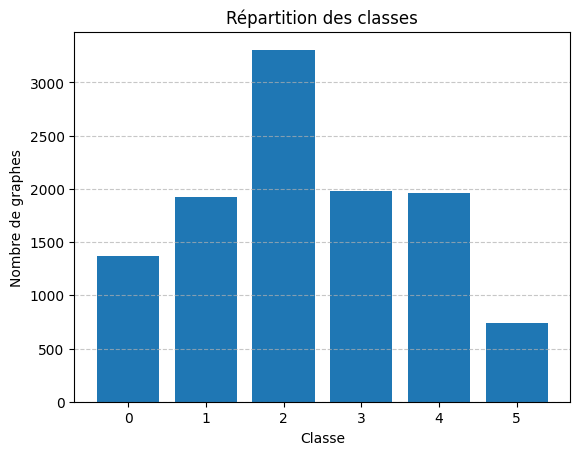

In [17]:
from collections import Counter
import matplotlib.pyplot as plt

# Récupère tous les labels dans le dataset
all_labels = [data.y.item() for data in full_dataset]

# Compte les occurrences de chaque classe
label_counts = Counter(all_labels)

print("Distribution des classes :")
for label, count in sorted(label_counts.items()):
    print(f"Classe {label} : {count} graphes")

# Optionnel : affichage visuel
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Classe")
plt.ylabel("Nombre de graphes")
plt.title("Répartition des classes")
plt.xticks(list(label_counts.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Dataset A - Test

In [7]:
full_dataset = GraphDataset('datasets/A/test.json.gz')

In [8]:
full_dataset

GraphDataset(2340)

In [9]:
full_dataset[0]

Data(edge_index=[2, 9506], edge_attr=[9506, 7], num_nodes=300)

In [10]:
# Print the features of edges : 1 raw = features for 1 edge
full_dataset[0].edge_attr

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.4420, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.4420, 0.0000, 0.0000],
        [0.0840, 0.0000, 0.0000,  ..., 0.6370, 0.2180, 0.0770],
        ...,
        [0.0740, 0.0000, 0.0000,  ..., 0.6270, 0.2910, 0.1220],
        [0.0000, 0.0000, 0.5150,  ..., 0.0000, 0.0000, 0.2470],
        [0.0000, 0.0000, 0.5150,  ..., 0.0000, 0.0000, 0.2470]])

## Dataset B - Train

In [7]:
full_dataset = GraphDataset('datasets/B/train.json.gz')

In [8]:
full_dataset

GraphDataset(5600)

In [9]:
full_dataset[0]

Data(edge_index=[2, 5026], edge_attr=[5026, 7], y=[1], num_nodes=300)

In [10]:
# Print the features of edges : 1 raw = features for 1 edge
full_dataset[0].edge_attr

tensor([[0.1100, 0.0000, 0.1700,  ..., 0.0000, 0.0000, 0.4730],
        [0.1100, 0.0000, 0.1700,  ..., 0.0000, 0.0000, 0.4730],
        [0.2060, 0.0000, 0.6880,  ..., 0.0000, 0.9000, 0.4730],
        ...,
        [0.0930, 0.0000, 0.2730,  ..., 0.3790, 0.0000, 0.1420],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5700],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.5700]])

Distribution des classes :
Classe 0 : 936 graphes
Classe 1 : 989 graphes
Classe 2 : 676 graphes
Classe 3 : 922 graphes
Classe 4 : 1425 graphes
Classe 5 : 652 graphes


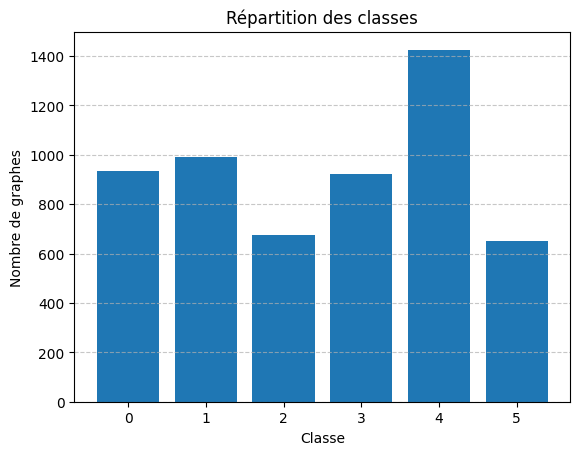

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

# Récupère tous les labels dans le dataset
all_labels = [data.y.item() for data in full_dataset]

# Compte les occurrences de chaque classe
label_counts = Counter(all_labels)

print("Distribution des classes :")
for label, count in sorted(label_counts.items()):
    print(f"Classe {label} : {count} graphes")

# Optionnel : affichage visuel
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Classe")
plt.ylabel("Nombre de graphes")
plt.title("Répartition des classes")
plt.xticks(list(label_counts.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Dataset C - Train

In [12]:
full_dataset = GraphDataset('datasets/C/train.json.gz')

In [13]:
full_dataset

GraphDataset(7680)

In [14]:
full_dataset[0]

Data(edge_index=[2, 886], edge_attr=[886, 7], y=[1], num_nodes=74)

In [15]:
# Print the features of edges : 1 raw = features for 1 edge
full_dataset[0].edge_attr

tensor([[0.1080, 0.0000, 0.0000,  ..., 0.0000, 0.9000, 0.0000],
        [0.1080, 0.0000, 0.0000,  ..., 0.0000, 0.9000, 0.0000],
        [0.1080, 0.0000, 0.0000,  ..., 0.0000, 0.9000, 0.0500],
        ...,
        [0.2320, 0.0000, 0.0000,  ..., 0.0000, 0.8000, 0.4940],
        [0.4550, 0.0000, 0.0000,  ..., 0.3280, 0.0000, 0.0990],
        [0.4550, 0.0000, 0.0000,  ..., 0.3280, 0.0000, 0.0990]])

Distribution des classes :
Classe 0 : 400 graphes
Classe 1 : 1480 graphes
Classe 2 : 3136 graphes
Classe 3 : 800 graphes
Classe 4 : 1144 graphes
Classe 5 : 720 graphes


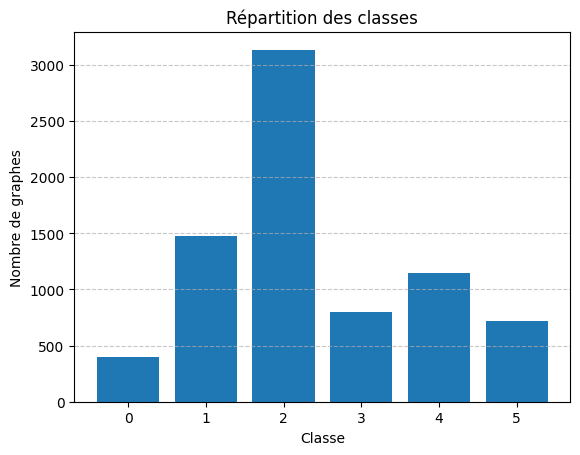

In [16]:
from collections import Counter
import matplotlib.pyplot as plt

# Récupère tous les labels dans le dataset
all_labels = [data.y.item() for data in full_dataset]

# Compte les occurrences de chaque classe
label_counts = Counter(all_labels)

print("Distribution des classes :")
for label, count in sorted(label_counts.items()):
    print(f"Classe {label} : {count} graphes")

# Optionnel : affichage visuel
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Classe")
plt.ylabel("Nombre de graphes")
plt.title("Répartition des classes")
plt.xticks(list(label_counts.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Dataset D - Train

In [17]:
full_dataset = GraphDataset('datasets/D/train.json.gz')

In [18]:
full_dataset

GraphDataset(10280)

In [19]:
full_dataset[0]

Data(edge_index=[2, 3022], edge_attr=[3022, 7], y=[1], num_nodes=206)

In [20]:
# Print the features of edges : 1 raw = features for 1 edge
full_dataset[0].edge_attr

tensor([[0.3400, 0.0090, 0.0000,  ..., 0.0000, 0.1630, 0.2620],
        [0.3400, 0.0090, 0.0000,  ..., 0.0000, 0.1630, 0.2620],
        [0.1510, 0.0000, 0.1830,  ..., 0.0000, 0.1970, 0.2490],
        ...,
        [0.8880, 0.0000, 0.1850,  ..., 0.0000, 0.0000, 0.0750],
        [0.0600, 0.0000, 0.0000,  ..., 0.0000, 0.5060, 0.1300],
        [0.0600, 0.0000, 0.0000,  ..., 0.0000, 0.5060, 0.1300]])

Distribution des classes :
Classe 0 : 2272 graphes
Classe 1 : 680 graphes
Classe 2 : 1880 graphes
Classe 3 : 2000 graphes
Classe 4 : 2808 graphes
Classe 5 : 640 graphes


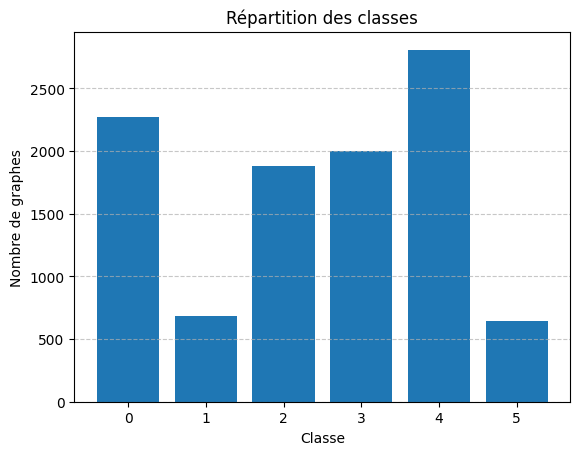

In [21]:
from collections import Counter
import matplotlib.pyplot as plt

# Récupère tous les labels dans le dataset
all_labels = [data.y.item() for data in full_dataset]

# Compte les occurrences de chaque classe
label_counts = Counter(all_labels)

print("Distribution des classes :")
for label, count in sorted(label_counts.items()):
    print(f"Classe {label} : {count} graphes")

# Optionnel : affichage visuel
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel("Classe")
plt.ylabel("Nombre de graphes")
plt.title("Répartition des classes")
plt.xticks(list(label_counts.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()